# Validation using AML31 case with Orthogonal Validation

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

%aimport deepsvr

Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.regularizers import l2
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from analysis_utils.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot, make_model_output_plot
from analysis_utils.Analysis import determine_feature_importance, print_accuracy_and_classification_report, predict_classes, get_somatic_error_type, calculate_kappa

sns.set_style("white")
sns.set_context('talk')

Using TensorFlow backend.


In [4]:
# Pull in training data
training_data = pd.read_pickle('../data/training_data.pkl')
# Remove AML31 case
training_data = training_data[~training_data.index.str.contains('H_KA-452198')]

In [5]:
# Show the calls associate with training data
training_data.groupby('call').size()

call
a    10658
f     9640
g     3144
s    18390
dtype: int64

In [6]:
# Re-label the germline calls as failed calls
three_class = training_data.replace('g','f')

# Condense disease types (solid = 1, liquid = 0)
s_v_b = three_class
s_v_b['solid_tumor'] = s_v_b[['disease_GST', 'disease_MPNST', 'disease_SCLC',
                              'disease_breast', 'disease_colorectal', 
                              'disease_glioblastoma', 'disease_melanoma']].apply(any, axis=1).astype(int)
s_v_b.drop(['disease_AML', 'disease_GST', 'disease_MPNST', 'disease_SCLC',
       'disease_breast', 'disease_colorectal', 'disease_glioblastoma',
       'disease_lymphoma', 'disease_melanoma'], axis=1, inplace=True)

# Show the calls associate with training data
s_v_b.groupby('call').size()


call
a    10658
f    12784
s    18390
dtype: int64

In [7]:
# Get labels for training data
Y = pd.get_dummies(three_class.call).astype(float).values
# Get training data as numpy array
X = s_v_b.sort_index(axis=1).drop(['call', 'reviewer_1',
                'reviewer_2', 'reviewer_3', 
                'reviewer_4'], axis=1).astype(float).values

In [8]:
# Pull in AML31 data
aml31 = pd.read_pickle('../data/aml31/train.pkl')

# Label disease type as liquid tumor (solid tumors are 0)
aml31['solid_tomor']=0

# Drop disease type and reviewer
aml31_X = aml31.sort_index(axis=1).drop(['disease_AML', 'reviewer_None'], axis=1).astype(float).values

In [9]:
# Test shape of AML31 data
aml31.shape

(192241, 61)

In [10]:
# Pull in results from orthogonal sequencing 
# platinum = pd.read_csv('../data/aml31/Supplemental_Dataset_3-PlatinumSnvList.tsv', sep='\t')
# platinum.rename(columns={'chromosome_name':'chr',  'reference':'ref', 'variant':'var'}, inplace=True)

platinum = pd.read_csv('../data/aml31/Supplemental_Dataset_3-PlatinumSnvList.tsv', sep='\t', index_col=0)

# Deep Learning Model

In [11]:
# Create function to define baseline model
def test_model():
    # create model
    model = Sequential()
    model.add(Dense(59, input_dim=59, kernel_initializer='normal', activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(20, activation='tanh', kernel_regularizer=l2(0.001)))
    model.add(Dense(3, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
# Set deep learning model parameters
test_estimator = KerasClassifier(build_fn=test_model, epochs=700, batch_size=2000, verbose=0)

# Fit model using training data
test_estimator.fit(X, Y)

# Employ trained model to predict AML31 variants
predictions = test_estimator.predict_proba(aml31_X)

In [14]:
# Add headers to predictions dataframe
predictions = pd.DataFrame(predictions, columns=['amb', 'fail', 'somatic'])

# Format predictions output
predictions.index = pd.DataFrame(aml31.index.str.split(' ').tolist(), columns=['sample_id', 'coord_id'])['coord_id']

# Pull prediction values
predictions['prediction'] = test_estimator.predict(aml31_X)


In [15]:
# Annotate the predictions file with coordinates from platinum list
m = pd.merge(predictions, platinum, how='left', left_index=True, right_index=True)

In [16]:
# If gene_name NA replace with 0
m.gene_name.fillna(0, inplace=True)

In [17]:
# Define iteration by row function
def row_is_null(row):
    if row==0:
        return 0
    else:
        return 1

In [18]:
# Apply row function to merged dataframe
m['validated'] = m['gene_name'].apply(row_is_null)

In [19]:
# Calculate false positive rate and true positive rate
dl_fpr, dl_tpr, _ = metrics.roc_curve(m.validated, m.somatic)
dl_auc = metrics.auc(dl_fpr, dl_tpr)

In [20]:
# Determine AUC for deep learning model
dl_auc

0.96967849874228118

# Random Forest Model

In [21]:
# Get Labels for random forest model
Y_rf = three_class.call.values

In [22]:
# Set random forest parameters
estimator = RandomForestClassifier(n_estimators=1000, max_features=8, 
                                   n_jobs=-1, oob_score=True)

# Fit model using training data
estimator.fit(X, Y_rf)

# Employ trained model to predict AML31 variants
predictions_rf = estimator.predict_proba(aml31_X)

In [23]:
# Add headers to predictions dataframe
predictions_rf = pd.DataFrame(predictions_rf, columns=['amb', 'fail', 'somatic'])

# Format predictions output
predictions_rf.index = pd.DataFrame(aml31.index.str.split(' ').tolist(), columns=['sample_id', 'coord_id'])['coord_id']

# Pull prediction values
predictions_rf['prediction'] = estimator.predict(aml31_X)


In [24]:
# Annotate the predictions file with coordinates from platinum list
m_rf = pd.merge(predictions_rf, platinum, how='left', left_index=True, right_index=True)

In [25]:
# If gene_name NA replace with 0
m_rf.gene_name.fillna(0, inplace=True)

In [26]:
# Apply row function to merged dataframe
m_rf['validated'] = m_rf['gene_name'].apply(row_is_null)

In [27]:
# Calculate false positive rate and true positive rate
rf_fpr, rf_tpr, _ = metrics.roc_curve(m_rf.validated, m_rf.somatic)
rf_auc = metrics.auc(rf_fpr, rf_tpr)

In [28]:
# Determine AUC for random forest model
rf_auc

0.96791524007849783

In [29]:
# Determine AUC for random forest model
rf_auc

0.96791524007849783

# Plot AUC Curves for DL and RF 

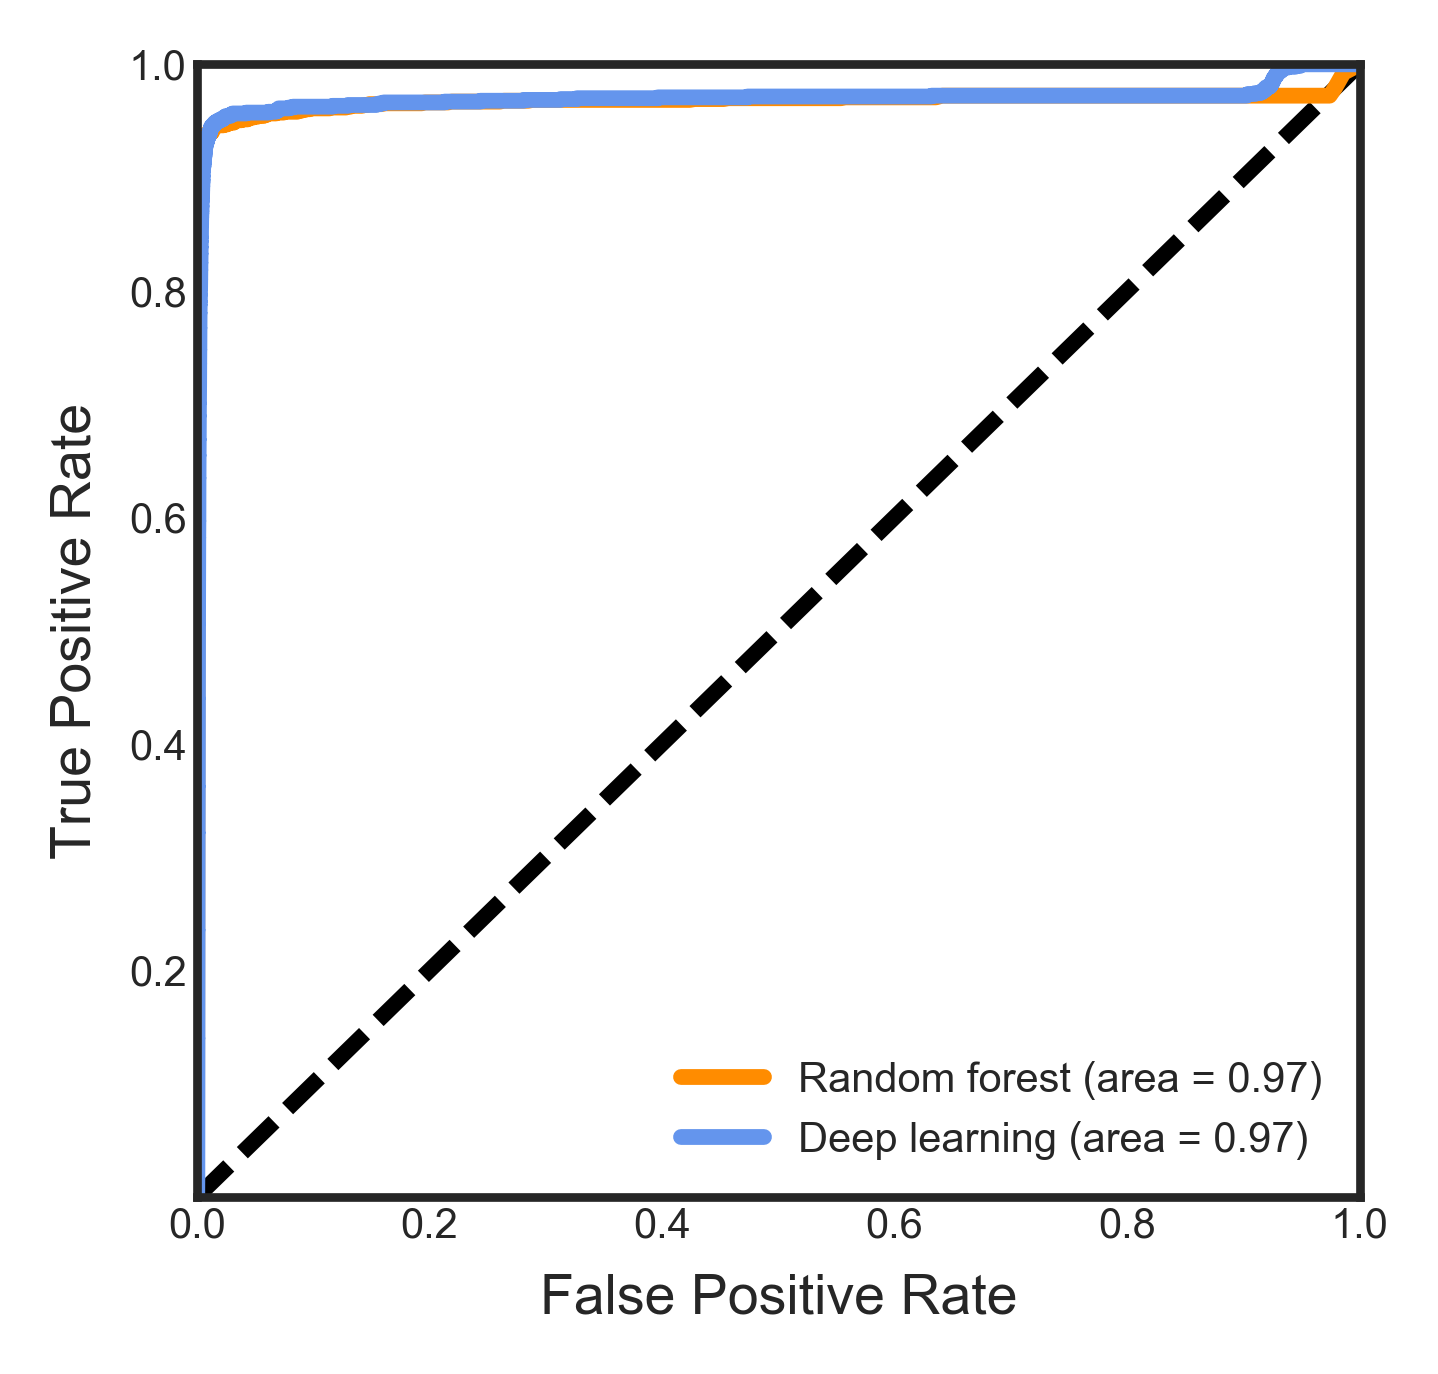

In [30]:
# Plot accuracy for random forest AUC and deep learning AUC
fig, (ax1) = plt.subplots(1, figsize=(3,3),dpi=500)
ax1.plot([0, 1], [0, 1], 'k--')
ax1.plot(rf_fpr, rf_tpr, color='darkorange', label='Random forest'
             ' (area = {0:0.2f})'.format(rf_auc))
ax1.plot(dl_fpr, dl_tpr, color='cornflowerblue', label='Deep learning'
             ' (area = {0:0.2f})'.format(dl_auc))
ax1.set_xlabel('False Positive Rate',fontsize=8)
ax1.set_ylabel('True Positive Rate',fontsize=8)
ax1.legend(fontsize=6)
ax1.tick_params(labelsize=6, pad=1.5)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.0])
ax1.set_yticklabels(['','0.2','0.4','0.6','0.8','1.0'])
fig.savefig('../figures/validation_performance.png')
fig.savefig('../figures/validation_performance.pdf')